In [1]:
import os
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

In [2]:
def get_device():
    if torch.cuda.is_available():
        device = 'cuda:0'
    else:
        device = 'cpu'
    return device

device = get_device()
print('Device: ',device)

Device:  cuda:0


In [3]:
# Paths
input_path = '/kaggle/input/2024-flame-ai-challenge/dataset/'

# Load data
train_df = pd.read_csv(os.path.join(input_path, 'train.csv'))
test_df = pd.read_csv(os.path.join(input_path, 'test.csv'))

# Function to load data
def load_dataX(idx, df, data_dir):
    csv_file = df.reset_index().to_dict(orient='list')
    dir_path = os.path.join(input_path, data_dir)
    
    id = csv_file['id'][idx]
    nt, Nx, Ny = csv_file['Nt'][idx], csv_file['Nx'][idx], csv_file['Ny'][idx]
    
    theta = np.fromfile(os.path.join(dir_path, csv_file['theta_filename'][idx]), dtype="<f4").reshape(nt, Nx, Ny)
    ustar = np.fromfile(os.path.join(dir_path, csv_file['ustar_filename'][idx]), dtype="<f4").reshape(nt, Nx, Ny)
    xi_f = np.fromfile(os.path.join(dir_path, csv_file['xi_filename'][idx]), dtype="<f4").reshape(nt, Nx, Ny)
    
    uin = csv_file['u'][idx]
    alpha = csv_file['alpha'][idx]

    return theta, ustar, xi_f, uin, alpha, id

# Function to extract fire positions
def extract_fire_positions(xi_f):
    return [np.argmax(np.mean(xi_f[t], axis=1)) for t in range(xi_f.shape[0])]

# Prepare training data
Datalist = []

for idx in range(len(train_df)):
    theta, ustar, xi_f, uin, alpha, id = load_dataX(idx, train_df, 'train')
    
    theta = torch.Tensor(theta).unsqueeze(1)
    ustar = torch.Tensor(ustar).unsqueeze(1)
    xi_f = torch.Tensor(xi_f).unsqueeze(1)
    
    uin_tensor = torch.zeros_like(xi_f) + uin
    alpha_tensor = torch.zeros_like(xi_f) + alpha
    
    TUXUA = torch.cat([theta,ustar,xi_f, uin_tensor, alpha_tensor], dim=1)
    TUXUA = TUXUA.unsqueeze(0)
    
    Datalist.append(TUXUA)
    
Data_train = torch.cat(Datalist)
print(Data_train.shape)

# Prepare testing data
Datalist = []

for idx in range(len(test_df)):
    theta, ustar, xi_f, uin, alpha, id = load_dataX(idx, test_df, 'test')
    
    theta = torch.Tensor(theta).unsqueeze(1)
    ustar = torch.Tensor(ustar).unsqueeze(1)
    xi_f = torch.Tensor(xi_f).unsqueeze(1)
    
    uin_tensor = torch.zeros_like(xi_f) + uin
    alpha_tensor = torch.zeros_like(xi_f) + alpha
    
    TUXUA = torch.cat([theta,ustar,xi_f, uin_tensor, alpha_tensor], dim=1)
    TUXUA = TUXUA.unsqueeze(0)
    
    Datalist.append(TUXUA)
    
Data_test = torch.cat(Datalist)
print(Data_test.shape)

D1 = Data_train.reshape([Data_train.shape[0]*Data_train.shape[1], Data_train.shape[2], Data_train.shape[3], Data_train.shape[4]])
D2 = Data_test.reshape([Data_test.shape[0]*Data_test.shape[1], Data_test.shape[2], Data_test.shape[3], Data_test.shape[4]])
print(D1.shape, D2.shape) 

D = torch.cat([D1,D2], dim=0)
MeanX = torch.mean(D, (0,2,3)).unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
StdX = torch.std(D, (0,2,3)).unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
print(StdX.shape)   # sample, timestep, channels [theta,ustar,xi_f, uin, alpha], X, Y
print(MeanX.shape)

MeanY = torch.mean(D, (0,2,3))[:3].unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
StdY = torch.std(D, (0,2,3))[:3].unsqueeze(0).unsqueeze(0).unsqueeze(-1).unsqueeze(-1).to(device)
print(StdY.shape)   # sample, timestep, channels [theta,ustar,xi_f], X, Y
print(MeanY.shape)

torch.Size([9, 150, 5, 113, 32])
torch.Size([27, 5, 5, 113, 32])
torch.Size([1350, 5, 113, 32]) torch.Size([135, 5, 113, 32])
torch.Size([1, 1, 5, 1, 1])
torch.Size([1, 1, 5, 1, 1])
torch.Size([1, 1, 3, 1, 1])
torch.Size([1, 1, 3, 1, 1])


In [4]:
# Create custom PyTorch dataset
class FlameDataset(Dataset):
    def __init__(self, Data, history = 1, prediction = 1):
        self.X = Data    #torch.Size([9, 150, 5, 113, 32])
        self.history = history
        self.prediction = prediction
        self.count_cases = Data.shape[0]
        self.count_timeIndices = Data.shape[1] - history - prediction + 1
        self.indices = torch.arange(self.count_cases*self.count_timeIndices)

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        case = idx%self.count_cases
        index = idx%self.count_timeIndices
        
        X = self.X[case,index:index + self.history,...]
        Y = self.X[case,index + self.history:index + self.history + self.prediction,:3,...]
        T = index + self.history #* torch.ones(idx.shape[0])
        return X, Y, T

In [5]:
class SpectralConv1d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1):
        super(SpectralConv1d, self).__init__()

        """
        1D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1  #Number of Fourier modes to multiply, at most floor(N/2) + 1

        self.scale = (1 / (in_channels*out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul1d(self, input, weights):
        # (batch, in_channel, x ), (in_channel, out_channel, x) -> (batch, out_channel, x)
        return torch.einsum("bix,iox->box", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft(x)

        # Multiply relevant Fourier modes 
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-1)//2 + 1,  device=x.device, dtype=torch.cfloat)
        out_ft[:, :, :self.modes1] = self.compl_mul1d(x_ft[:, :, :self.modes1], self.weights1)

        #Return to physical space
        x = torch.fft.irfft(out_ft, n=x.size(-1))
        return x

class FNO1d(nn.Module):
    def __init__(self, num_channels, modes=16, width=64, initial_step=10):
        super(FNO1d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the initial condition and location (a(x), x)
        input shape: (batchsize, x=s, c=2)
        output: the solution of a later timestep
        output shape: (batchsize, x=s, c=1)
        """

        self.modes1 = modes
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(initial_step*num_channels+1, self.width) # input channel is 2: (a(x), x)

        self.conv0 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv1 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv2 = SpectralConv1d(self.width, self.width, self.modes1)
        self.conv3 = SpectralConv1d(self.width, self.width, self.modes1)
        self.w0 = nn.Conv1d(self.width, self.width, 1)
        self.w1 = nn.Conv1d(self.width, self.width, 1)
        self.w2 = nn.Conv1d(self.width, self.width, 1)
        self.w3 = nn.Conv1d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, num_channels)

    def forward(self, x):
        # x dim = [b, x1, t*v]
        #x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 2, 1)
        
        x = F.pad(x, [0, self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding]
        x = x.permute(0, 2, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x.unsqueeze(-2)


class SpectralConv2d_fast(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2):
        super(SpectralConv2d_fast, self).__init__()

        """
        2D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul2d(self, input, weights):
        # (batch, in_channel, x,y ), (in_channel, out_channel, x,y) -> (batch, out_channel, x,y)
        return torch.einsum("bixy,ioxy->boxy", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfft2(x)

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels,  x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, :self.modes1, :self.modes2], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2] = \
            self.compl_mul2d(x_ft[:, :, -self.modes1:, :self.modes2], self.weights2)

        #Return to physical space
        x = torch.fft.irfft2(out_ft, s=(x.size(-2), x.size(-1)))
        return x

class FNO2d(nn.Module):
    def __init__(self, num_channels, modes1=12, modes2=12, width=20, initial_step=10, predict=1):
        super(FNO2d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)
        input shape: (batchsize, x, y, c)
        output: the solution of the next timestep
        output shape: (batchsize, x, y, c)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.width = width
        self.padding = 2 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(initial_step*num_channels, self.width)
        # input channel is 12: the solution of the previous 10 timesteps + 2 locations (u(t-10, x, y), ..., u(t-1, x, y),  x, y)

        self.conv0 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv1 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv2 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.conv3 = SpectralConv2d_fast(self.width, self.width, self.modes1, self.modes2)
        self.w0 = nn.Conv2d(self.width, self.width, 1)
        self.w1 = nn.Conv2d(self.width, self.width, 1)
        self.w2 = nn.Conv2d(self.width, self.width, 1)
        self.w3 = nn.Conv2d(self.width, self.width, 1)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, predict)

    def forward(self, x):
        # x dim = [b, x1, x2, t*v]   
        #x = torch.cat((x, grid), dim=-1)
        x = x.permute(0, 2, 3, 1)
        x = self.fc0(x)
        x = x.permute(0, 3, 1, 2)
        
        # Pad tensor with boundary condition
        x = F.pad(x, [0, self.padding, 0, self.padding])

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding, :-self.padding] # Unpad the tensor
        x = x.permute(0, 2, 3, 1)
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        x = x.permute(0, 3, 1, 2)
        return x
    

class SpectralConv3d(nn.Module):
    def __init__(self, in_channels, out_channels, modes1, modes2, modes3):
        super(SpectralConv3d, self).__init__()

        """
        3D Fourier layer. It does FFT, linear transform, and Inverse FFT.    
        """

        self.in_channels = in_channels
        self.out_channels = out_channels
        self.modes1 = modes1 #Number of Fourier modes to multiply, at most floor(N/2) + 1
        self.modes2 = modes2
        self.modes3 = modes3

        self.scale = (1 / (in_channels * out_channels))
        self.weights1 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights2 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights3 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))
        self.weights4 = nn.Parameter(self.scale * torch.rand(in_channels, out_channels, self.modes1, self.modes2, self.modes3, dtype=torch.cfloat))

    # Complex multiplication
    def compl_mul3d(self, input, weights):
        # (batch, in_channel, x,y,t ), (in_channel, out_channel, x,y,t) -> (batch, out_channel, x,y,t)
        return torch.einsum("bixyz,ioxyz->boxyz", input, weights)

    def forward(self, x):
        batchsize = x.shape[0]
        #Compute Fourier coeffcients up to factor of e^(- something constant)
        x_ft = torch.fft.rfftn(x, dim=[-3,-2,-1])

        # Multiply relevant Fourier modes
        out_ft = torch.zeros(batchsize, self.out_channels, x.size(-3), x.size(-2), x.size(-1)//2 + 1, dtype=torch.cfloat, device=x.device)
        out_ft[:, :, :self.modes1, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, :self.modes2, :self.modes3], self.weights1)
        out_ft[:, :, -self.modes1:, :self.modes2, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, :self.modes2, :self.modes3], self.weights2)
        out_ft[:, :, :self.modes1, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, :self.modes1, -self.modes2:, :self.modes3], self.weights3)
        out_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3] = \
            self.compl_mul3d(x_ft[:, :, -self.modes1:, -self.modes2:, :self.modes3], self.weights4)

        #Return to physical space
        x = torch.fft.irfftn(out_ft, s=(x.size(-3), x.size(-2), x.size(-1)))
        return x

class FNO3d(nn.Module):
    def __init__(self, num_channels, modes1=8, modes2=8, modes3=8, width=20, initial_step=10):
        super(FNO3d, self).__init__()

        """
        The overall network. It contains 4 layers of the Fourier layer.
        1. Lift the input to the desire channel dimension by self.fc0 .
        2. 4 layers of the integral operators u' = (W + K)(u).
            W defined by self.w; K defined by self.conv .
        3. Project from the channel space to the output space by self.fc1 and self.fc2 .
        
        input: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t). It's a constant function in time, except for the last index.
        input shape: (batchsize, x=64, y=64, t=40, c=13)
        output: the solution of the next 40 timesteps
        output shape: (batchsize, x=64, y=64, t=40, c=1)
        """

        self.modes1 = modes1
        self.modes2 = modes2
        self.modes3 = modes3
        self.width = width
        self.padding = 6 # pad the domain if input is non-periodic
        self.fc0 = nn.Linear(initial_step*num_channels+3, self.width)
        # input channel is 12: the solution of the first 10 timesteps + 3 locations (u(1, x, y), ..., u(10, x, y),  x, y, t)

        self.conv0 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv1 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv2 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.conv3 = SpectralConv3d(self.width, self.width, self.modes1, self.modes2, self.modes3)
        self.w0 = nn.Conv3d(self.width, self.width, 1)
        self.w1 = nn.Conv3d(self.width, self.width, 1)
        self.w2 = nn.Conv3d(self.width, self.width, 1)
        self.w3 = nn.Conv3d(self.width, self.width, 1)
        self.bn0 = torch.nn.BatchNorm3d(self.width)
        self.bn1 = torch.nn.BatchNorm3d(self.width)
        self.bn2 = torch.nn.BatchNorm3d(self.width)
        self.bn3 = torch.nn.BatchNorm3d(self.width)

        self.fc1 = nn.Linear(self.width, 128)
        self.fc2 = nn.Linear(128, num_channels)

    def forward(self, x):
        # x dim = [b, x1, x2, x3, t*v]
        #x = torch.cat((x, grid), dim=-1)
        x = self.fc0(x)
        x = x.permute(0, 4, 1, 2, 3)
        
        x = F.pad(x, [0, self.padding]) # pad the domain if input is non-periodic

        x1 = self.conv0(x)
        x2 = self.w0(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv1(x)
        x2 = self.w1(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv2(x)
        x2 = self.w2(x)
        x = x1 + x2
        x = F.gelu(x)

        x1 = self.conv3(x)
        x2 = self.w3(x)
        x = x1 + x2

        x = x[..., :-self.padding]
        x = x.permute(0, 2, 3, 4, 1) # pad the domain if input is non-periodic
        x = self.fc1(x)
        x = F.gelu(x)
        x = self.fc2(x)
        return x.unsqueeze(-2)

# model = FNO2d(num_channels=1, modes1=16, modes2=16, width=42, initial_step=history, predict=prediction)

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

def sinusoidal_embedding(n, d, device):
    # Returns the standard positional embedding
    embedding = torch.zeros(n, d).to(device)
    wk = torch.tensor([1 / 10_000 ** (2 * j / d) for j in range(d)]).to(device)
    wk = wk.reshape((1, d))
    t = torch.arange(n).reshape((n, 1)).to(device)
    embedding[:, ::2] = torch.sin(t * wk[:, ::2]).to(device)
    embedding[:, 1::2] = torch.cos(t * wk[:, ::2]).to(device)

    return embedding

class DoubleConv(nn.Module):
    """(convolution => [BN] => ReLU) * 2"""

    def __init__(self, in_channels, out_channels, mid_channels=None):
        super().__init__()
        if not mid_channels:
            mid_channels = out_channels
        self.double_conv = nn.Sequential(
            nn.Conv2d(in_channels, mid_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(mid_channels),
            nn.ReLU(inplace=True),
            nn.Conv2d(mid_channels, out_channels, kernel_size=3, padding=1, bias=False),
            nn.BatchNorm2d(out_channels),
            nn.ReLU(inplace=True)
            #nn.LeakyReLU(1., inplace=True)    # to allow negative output
        )
        #self.fno_layer = FNO2d(num_channels=1, modes1=16, modes2=16, width=42, initial_step=out_channels, predict=out_channels)

    def forward(self, x):
        x = self.double_conv(x)
        #x = self.fno_layer(x)
        return x


class Down(nn.Module):
    """Downscaling with maxpool then double conv"""

    def __init__(self, in_channels, out_channels):
        super().__init__()
        self.maxpool_conv = nn.Sequential(
            nn.MaxPool2d(2),
            DoubleConv(in_channels, out_channels)
        )

    def forward(self, x):
        return self.maxpool_conv(x)


class Up(nn.Module):
    """Upscaling then double conv"""

    def __init__(self, in_channels, out_channels, bilinear=True):
        super().__init__()

        # if bilinear, use the normal convolutions to reduce the number of channels
        if bilinear:
            self.up = nn.Upsample(scale_factor=2, mode='bilinear', align_corners=True)
            self.conv = DoubleConv(in_channels, out_channels, in_channels // 2)
        else:
            self.up = nn.ConvTranspose2d(in_channels, in_channels // 2, kernel_size=2, stride=2)
            self.conv = DoubleConv(in_channels, out_channels)
        #self.fno_layerUp = FNO2d(num_channels=1, modes1=16, modes2=16, width=42, initial_step=out_channels, predict=out_channels)

    def forward(self, x1, x2):
        x1 = self.up(x1)
        # input is CHW
        diffY = x2.size()[2] - x1.size()[2]
        diffX = x2.size()[3] - x1.size()[3]

        #x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
        #                diffY // 2, diffY - diffY // 2])
        #breakpoint()
        # basically diffX diffY are placeholder without any value unless data is passed, so feature extractor fails
        #x1 = F.pad(x1, (int(str(diffX)) // 2, int(str(diffX)) - int(str(diffX)) // 2,
        #                int(str(diffY)) // 2, int(str(diffY)) - int(str(diffY)) // 2))     # get_graph_node_names was creating problem
        x1 = F.pad(x1, [diffX // 2, diffX - diffX // 2,
                        diffY // 2, diffY - diffY // 2])
        #
        # if you have padding issues, see
        # https://github.com/HaiyongJiang/U-Net-Pytorch-Unstructured-Buggy/commit/0e854509c2cea854e247a9c615f175f76fbb2e3a
        # https://github.com/xiaopeng-liao/Pytorch-UNet/commit/8ebac70e633bac59fc22bb5195e513d5832fb3bd
        x = torch.cat([x2, x1], dim=1)
        x = self.conv(x)
        #x = self.fno_layerUp(x)
        return x


class OutConv(nn.Module):
    def __init__(self, in_channels, out_channels):
        super(OutConv, self).__init__()
        self.conv = nn.Conv2d(in_channels, out_channels, kernel_size=1)

    def forward(self, x):
        return self.conv(x)


class UNet(nn.Module):
    def __init__(self, n_filters = 4, n_channels=3, n_classes=1, n_inner=8, bilinear=False, uin_steps = 10, alpha_steps = 300, time_emb_dim=100, device = 'cpu'):
        super(UNet, self).__init__()
        self.n_channels = n_channels        
        self.n_classes = n_classes
        self.n_inner = n_inner
        self.bilinear = bilinear
        self.device = device
        self.uin_steps = uin_steps
        self.alpha_steps = alpha_steps

        # Sinusoidal embedding
        self.alpha_embed = nn.Embedding(alpha_steps, time_emb_dim, device=device)
        self.alpha_embed.weight.data = sinusoidal_embedding(alpha_steps, time_emb_dim, device)
        self.alpha_embed.requires_grad_(False)
        
        self.uin_embed = nn.Embedding(uin_steps, time_emb_dim, device=device)
        self.uin_embed.weight.data = sinusoidal_embedding(uin_steps, time_emb_dim, device)
        self.uin_embed.requires_grad_(False)
         
        self.alpha_encoding_open = self._make_te(time_emb_dim, n_channels)
        self.uin_encoding_open = self._make_te(time_emb_dim, n_channels)

        self.alpha_encoding_inner1 = self._make_te(time_emb_dim, n_inner)
        self.uin_encoding_inner1 = self._make_te(time_emb_dim, n_inner)

        self.alpha_encoding_inner2 = self._make_te(time_emb_dim, n_inner)
        self.uin_encoding_inner2 = self._make_te(time_emb_dim, n_inner)

        self.alpha_encoding_inner3 = self._make_te(time_emb_dim, n_inner)
        self.uin_encoding_inner3 = self._make_te(time_emb_dim, n_inner)

        self.alpha_encoding_inner4 = self._make_te(time_emb_dim, n_inner)
        self.uin_encoding_inner4 = self._make_te(time_emb_dim, n_inner)

        self.alpha_encoding_inner5 = self._make_te(time_emb_dim, n_inner)
        self.uin_encoding_inner5 = self._make_te(time_emb_dim, n_inner)

        self.alpha_encoding_inner6 = self._make_te(time_emb_dim, n_inner)
        self.uin_encoding_inner6 = self._make_te(time_emb_dim, n_inner)

        self.alpha_encoding_inner7 = self._make_te(time_emb_dim, n_inner)
        self.uin_encoding_inner7 = self._make_te(time_emb_dim, n_inner)

        self.alpha_encoding_inner8 = self._make_te(time_emb_dim, n_inner)
        self.uin_encoding_inner8 = self._make_te(time_emb_dim, n_inner)
        
        self.alpha_encoding_inner9 = self._make_te(time_emb_dim, n_inner)
        self.uin_encoding_inner9 = self._make_te(time_emb_dim, n_inner)
        
        self.alpha_encoding_inner10 = self._make_te(time_emb_dim, n_inner)
        self.uin_encoding_inner10 = self._make_te(time_emb_dim, n_inner)

        self.alpha_encoding_close = self._make_te(time_emb_dim, n_inner)
        self.uin_encoding_close = self._make_te(time_emb_dim, n_inner)

#         self.inc = (DoubleConv(n_channels, n_filters))
        
#         self.te1 = self._make_te(time_emb_dim, n_filters)
#         self.down1 = (Down(n_filters, 2*n_filters))
        
#         self.te2 = self._make_te(time_emb_dim, 2*n_filters)
#         self.down2 = (Down(2*n_filters, 4*n_filters))
        
#         self.te3 = self._make_te(time_emb_dim, 4*n_filters)
#         self.down3 = (Down(4*n_filters, 8*n_filters))
        
#         factor = 2 if bilinear else 1
        
#         self.te4 = self._make_te(time_emb_dim, 8*n_filters)
#         self.down4 = (Down(8*n_filters, 16*n_filters // factor))
        
#         self.teu1i = self._make_te(time_emb_dim, 16*n_filters)       
#         self.teu1j = self._make_te(time_emb_dim, 8*n_filters)       
#         self.up1 = (Up(16*n_filters, 8*n_filters // factor, bilinear))
        
#         self.teu2i = self._make_te(time_emb_dim, 8*n_filters)
#         self.teu2j = self._make_te(time_emb_dim, 4*n_filters)       
#         self.up2 = (Up(8*n_filters, 4*n_filters // factor, bilinear))
        
#         self.teu3i = self._make_te(time_emb_dim, 4*n_filters)
#         self.teu3j = self._make_te(time_emb_dim, 2*n_filters)       
#         self.up3 = (Up(4*n_filters, 2*n_filters // factor, bilinear))
        
#         self.teu4i = self._make_te(time_emb_dim, 2*n_filters)
#         self.teu4j = self._make_te(time_emb_dim, n_filters)       
#         self.up4 = (Up(2*n_filters, n_filters, bilinear))
        
#         self.teo = self._make_te(time_emb_dim, n_filters)
#         self.outc = (OutConv(n_filters, n_classes)) # DoubleConv(n_fliters,n_classes)  # (OutConv(64, n_classes))    #1x1 conv can allow negative values in output to be mapped
        self.fno_layer_1st = FNO2d(num_channels=1, modes1=16, modes2=16, width=96, initial_step=n_channels, predict=n_inner)
        self.fno_layer_inner1 = FNO2d(num_channels=1, modes1=12, modes2=12, width=20, initial_step=n_inner, predict=n_inner)
        self.fno_layer_inner2 = FNO2d(num_channels=1, modes1=12, modes2=12, width=20, initial_step=n_inner, predict=n_inner)
        self.fno_layer_inner3 = FNO2d(num_channels=1, modes1=12, modes2=12, width=20, initial_step=n_inner, predict=n_inner)
        self.fno_layer_inner4 = FNO2d(num_channels=1, modes1=12, modes2=12, width=20, initial_step=n_inner, predict=n_inner)
        self.fno_layer_inner5 = FNO2d(num_channels=1, modes1=12, modes2=12, width=20, initial_step=n_inner, predict=n_inner)
#         self.fno_layer_inner6 = FNO2d(num_channels=1, modes1=12, modes2=12, width=20, initial_step=n_inner, predict=n_inner)
#         self.fno_layer_inner7 = FNO2d(num_channels=1, modes1=12, modes2=12, width=20, initial_step=n_inner, predict=n_inner)
#         self.fno_layer_inner8 = FNO2d(num_channels=1, modes1=12, modes2=12, width=20, initial_step=n_inner, predict=n_inner)
#         self.fno_layer_inner9 = FNO2d(num_channels=1, modes1=12, modes2=12, width=20, initial_step=n_inner, predict=n_inner)
#         self.fno_layer_inner10 = FNO2d(num_channels=1, modes1=12, modes2=12, width=20, initial_step=n_inner, predict=n_inner)
        self.fno_layer_last = FNO2d(num_channels=1, modes1=16, modes2=16, width=96, initial_step=n_inner, predict=n_classes)
        
        
    def forward(self, x, t):
        
        # x has 5 channels [theta,ustar,xi_f, uin_tensor, alpha_tensor]
        # variables for embedding  # passed to nn positional encoding hence has to be integer or long integer
        uin =x[:,0,3,0,0].long()   
        alpha = (x[:,0,4,0,0]*10.).long()
        
        #print(alpha)
        x = (x - MeanX)/StdX        
        # print(x.shape)     # [32, 4, 5, 113, 32]
        
        x = x[:,:,:3,:,:]
        Xshape = x.shape
        #print(x.shape)
        x = x.reshape([Xshape[0], Xshape[1] * Xshape[2], Xshape[3], Xshape[4]])
        
        n = len(x)
        #x_ = x   
        
        uin = self.uin_embed(uin)  # takes in long or int tensor not float
        alpha = self.alpha_embed(alpha)
        
        uin_open = self.uin_encoding_open(uin).reshape(n, -1, 1, 1)
        alpha_open = self.uin_encoding_open(alpha).reshape(n, -1, 1, 1)
        
        uin_inner1 = self.uin_encoding_inner1(uin).reshape(n, -1, 1, 1)
        alpha_inner1 = self.uin_encoding_inner1(alpha).reshape(n, -1, 1, 1)
        
        uin_inner2 = self.uin_encoding_inner2(uin).reshape(n, -1, 1, 1)
        alpha_inner2 = self.uin_encoding_inner2(alpha).reshape(n, -1, 1, 1)
        
        uin_inner3 = self.uin_encoding_inner3(uin).reshape(n, -1, 1, 1)
        alpha_inner3 = self.uin_encoding_inner3(alpha).reshape(n, -1, 1, 1)
        
        uin_inner4 = self.uin_encoding_inner4(uin).reshape(n, -1, 1, 1)
        alpha_inner4 = self.uin_encoding_inner4(alpha).reshape(n, -1, 1, 1)
        
        uin_inner5 = self.uin_encoding_inner5(uin).reshape(n, -1, 1, 1)
        alpha_inner5 = self.uin_encoding_inner5(alpha).reshape(n, -1, 1, 1)
        
#         uin_inner6 = self.uin_encoding_inner6(uin).reshape(n, -1, 1, 1)
#         alpha_inner6 = self.uin_encoding_inner6(alpha).reshape(n, -1, 1, 1)
        
#         uin_inner7 = self.uin_encoding_inner7(uin).reshape(n, -1, 1, 1)
#         alpha_inner7 = self.uin_encoding_inner7(alpha).reshape(n, -1, 1, 1)
        
#         uin_inner8 = self.uin_encoding_inner8(uin).reshape(n, -1, 1, 1)
#         alpha_inner8 = self.uin_encoding_inner8(alpha).reshape(n, -1, 1, 1)
        
#         uin_inner9 = self.uin_encoding_inner9(uin).reshape(n, -1, 1, 1)
#         alpha_inner9 = self.uin_encoding_inner9(alpha).reshape(n, -1, 1, 1)
        
#         uin_inner10 = self.uin_encoding_inner10(uin).reshape(n, -1, 1, 1)
#         alpha_inner10 = self.uin_encoding_inner10(alpha).reshape(n, -1, 1, 1)
        
        uin_close = self.uin_encoding_close(uin).reshape(n, -1, 1, 1)
        alpha_close = self.uin_encoding_close(alpha).reshape(n, -1, 1, 1)
        
#         x1 = self.inc(x + self.tei(t).reshape(n, -1, 1, 1))
#         x2 = self.down1(x1 + self.te1(t).reshape(n, -1, 1, 1))
#         x3 = self.down2(x2 + self.te2(t).reshape(n, -1, 1, 1))
#         x4 = self.down3(x3 + self.te3(t).reshape(n, -1, 1, 1))
#         x5 = self.down4(x4 + self.te4(t).reshape(n, -1, 1, 1))
#         x = self.up1(x5 + self.teu1i(t).reshape(n, -1, 1, 1), x4 + self.teu1j(t).reshape(n, -1, 1, 1))
#         x = self.up2(x + self.teu2i(t).reshape(n, -1, 1, 1), x3 + self.teu2j(t).reshape(n, -1, 1, 1))
#         x = self.up3(x + self.teu3i(t).reshape(n, -1, 1, 1), x2 + self.teu3j(t).reshape(n, -1, 1, 1))
#         x = self.up4(x + self.teu4i(t).reshape(n, -1, 1, 1), x1 + self.teu4j(t).reshape(n, -1, 1, 1))
#         x = self.outc(x + self.teo(t).reshape(n, -1, 1, 1))
        
        x = self.fno_layer_1st(x + uin_open + alpha_open)
        
        #inner layers
        x = self.fno_layer_inner1(x + uin_inner1 + alpha_inner1) + x
        x = self.fno_layer_inner2(x + uin_inner2 + alpha_inner2) + x
        x = self.fno_layer_inner3(x + uin_inner3 + alpha_inner3) + x
        x = self.fno_layer_inner4(x + uin_inner4 + alpha_inner4) + x
        x = self.fno_layer_inner5(x + uin_inner5 + alpha_inner5) + x
#         x = self.fno_layer_inner6(x + uin_inner6 + alpha_inner6) + x
#         x = self.fno_layer_inner7(x + uin_inner7 + alpha_inner7) + x
#         x = self.fno_layer_inner8(x + uin_inner8 + alpha_inner8) + x
#         x = self.fno_layer_inner9(x + uin_inner9 + alpha_inner9) + x
#         x = self.fno_layer_inner10(x + uin_inner10 + alpha_inner10) + x
        
        x = self.fno_layer_last(x + uin_close + alpha_close)
        
        x = x.reshape([Xshape[0], 1, 3, Xshape[3], Xshape[4]])
        
        x = (x * StdY) + MeanY
        
#         #x = 0.01*x + x_[:,-1:,:3,:,:]
#         x[:,:,2:,:,:][x[:,:,2:,:,:]>=0.25] = 1.        
        x[:,:,2:,:,:][x[:,:,2:,:,:]<0.02] = 0.        
        
        #print(x.shape)  32,T,3,113,32
        
        return x
        # logits = self.outc(x)
        # return logits
        
    def _make_te(self, dim_in, dim_out):
        return nn.Sequential(
            nn.Linear(dim_in, dim_out), nn.SiLU(), nn.Linear(dim_out, dim_out)
        )

def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
# Model parameters
batch_size = 32
learning_rate = 1e-3
num_epochs = 100
num_filters = 64
history = 4
prediction = 1

# Create dataset and dataloaders for training and test sets
train_dataset = FlameDataset(Data_train, history = history, prediction = prediction)
test_dataset = FlameDataset(Data_test, history = history, prediction = prediction)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

# Initialize the model, loss function, and optimizer
model = UNet(n_filters = num_filters, n_channels = 3 * history, n_classes = 3 * prediction, device=device).to(device)
best_model = UNet(n_filters = num_filters, n_channels = 3 * history, n_classes = 3 * prediction, device=device).to(device)
print('Number of model parameters = %3d'%(count_parameters(model)))

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

Number of model parameters = 40205591


In [8]:
#model = torch.load("model.pth")

In [9]:
# Train the model
train_loss = []
validation_loss = []
best_loss = 10000
best_epoch = 0
for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    for xx,yy,tt  in train_loader:
        xx = xx.to(device)
        yy = yy.to(device)
        tt = tt.to(device)
        optimizer.zero_grad()
        outputs = model(xx, tt*0.)
        
        theta_misfit = criterion(outputs[:,:,0:1,:,:], yy[:,:,0:1,:,:])/criterion(outputs[:,:,0:1,:,:]*0., yy[:,:,0:1,:,:])  
        ustar_misfit = criterion(outputs[:,:,1:2,:,:], yy[:,:,1:2,:,:])/criterion(outputs[:,:,1:2,:,:]*0., yy[:,:,1:2,:,:]) 
        xi_f_misfit = criterion(outputs[:,:,2:3,:,:], yy[:,:,2:3,:,:])/criterion(outputs[:,:,2:3,:,:]*0., yy[:,:,2:3,:,:])
        
        loss = theta_misfit + ustar_misfit + xi_f_misfit
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
#     for xx,yy,tt  in test_loader:
#         xx = xx.to(device)
#         yy = yy.to(device)
#         tt = tt.to(device)
#         optimizer.zero_grad()
#         outputs = model(xx, tt*0.)
        
#         theta_misfit = criterion(outputs[:,:,0:1,:,:], yy[:,:,0:1,:,:])/criterion(outputs[:,:,0:1,:,:]*0., yy[:,:,0:1,:,:])  
#         ustar_misfit = criterion(outputs[:,:,1:2,:,:], yy[:,:,1:2,:,:])/criterion(outputs[:,:,1:2,:,:]*0., yy[:,:,1:2,:,:]) 
#         xi_f_misfit = criterion(outputs[:,:,2:3,:,:], yy[:,:,2:3,:,:])/criterion(outputs[:,:,2:3,:,:]*0., yy[:,:,2:3,:,:])
        
#         loss = theta_misfit + ustar_misfit + xi_f_misfit
        
#         loss.backward()
#         optimizer.step()
    
    for xx,yy,tt  in test_loader:
        xx = xx.to(device)
        yy = yy.to(device)
        tt = tt.to(device)
        with torch.no_grad():
            outputs = model(xx, tt*0.)
        
            val_loss = criterion(outputs, yy)
        running_val_loss += val_loss.item()
    
    trn_loss = running_loss/len(train_loader)
    val_loss = running_val_loss/len(test_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {trn_loss:.3e}, Validation Loss: {val_loss:.3e}")
    
    train_loss.append(trn_loss)
    validation_loss.append(val_loss)
    
    if val_loss <= best_loss:
        best_model.load_state_dict(model.state_dict())
        torch.save(best_model, 'best_model.pth')
        best_epoch = epoch
        best_loss = val_loss
    torch.save(model, 'model.pth')

Epoch [1/100], Train Loss: 6.638e-01, Validation Loss: 1.514e+02
Epoch [2/100], Train Loss: 3.376e-01, Validation Loss: 2.012e+02
Epoch [3/100], Train Loss: 3.085e-01, Validation Loss: 2.294e+02
Epoch [4/100], Train Loss: 2.924e-01, Validation Loss: 2.264e+02
Epoch [5/100], Train Loss: 2.807e-01, Validation Loss: 2.349e+02
Epoch [6/100], Train Loss: 2.648e-01, Validation Loss: 1.899e+02
Epoch [7/100], Train Loss: 2.495e-01, Validation Loss: 1.539e+02
Epoch [8/100], Train Loss: 2.336e-01, Validation Loss: 1.585e+02
Epoch [9/100], Train Loss: 2.031e-01, Validation Loss: 1.429e+02
Epoch [10/100], Train Loss: 1.822e-01, Validation Loss: 1.507e+02
Epoch [11/100], Train Loss: 1.528e-01, Validation Loss: 1.617e+02
Epoch [12/100], Train Loss: 1.400e-01, Validation Loss: 1.368e+02
Epoch [13/100], Train Loss: 1.133e-01, Validation Loss: 1.541e+02
Epoch [14/100], Train Loss: 9.420e-02, Validation Loss: 1.398e+02
Epoch [15/100], Train Loss: 8.159e-02, Validation Loss: 1.415e+02
Epoch [16/100], Tra

best epoch:  91


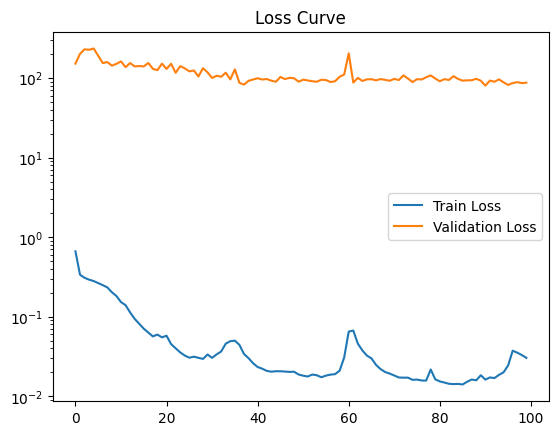

In [10]:
torch.save(model, 'model.pth')
print('best epoch: ', best_epoch + 1)

plt.plot(train_loss, label="Train Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.legend()
plt.yscale("log")
plt.title("Loss Curve")
plt.show()

In [11]:
# Train the model AGAIN
learning_rate = 1e-4
num_epochs = 500
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    for xx,yy,tt  in train_loader:
        xx = xx.to(device)
        yy = yy.to(device)
        tt = tt.to(device)
        optimizer.zero_grad()
        outputs = model(xx, tt*0.)
        
        theta_misfit = criterion(outputs[:,:,0:1,:,:], yy[:,:,0:1,:,:])/criterion(outputs[:,:,0:1,:,:]*0., yy[:,:,0:1,:,:])  
        ustar_misfit = criterion(outputs[:,:,1:2,:,:], yy[:,:,1:2,:,:])/criterion(outputs[:,:,1:2,:,:]*0., yy[:,:,1:2,:,:]) 
        xi_f_misfit = criterion(outputs[:,:,2:3,:,:], yy[:,:,2:3,:,:])/criterion(outputs[:,:,2:3,:,:]*0., yy[:,:,2:3,:,:])
        
        loss = theta_misfit + ustar_misfit + xi_f_misfit
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    for xx,yy,tt  in test_loader:
        xx = xx.to(device)
        yy = yy.to(device)
        tt = tt.to(device)
        optimizer.zero_grad()
        outputs = model(xx, tt*0.)
        
        theta_misfit = criterion(outputs[:,:,0:1,:,:], yy[:,:,0:1,:,:])/criterion(outputs[:,:,0:1,:,:]*0., yy[:,:,0:1,:,:])  
        ustar_misfit = criterion(outputs[:,:,1:2,:,:], yy[:,:,1:2,:,:])/criterion(outputs[:,:,1:2,:,:]*0., yy[:,:,1:2,:,:]) 
        xi_f_misfit = criterion(outputs[:,:,2:3,:,:], yy[:,:,2:3,:,:])/criterion(outputs[:,:,2:3,:,:]*0., yy[:,:,2:3,:,:])
        
        loss = theta_misfit + ustar_misfit + xi_f_misfit
        
        loss.backward()
        optimizer.step()
    
    for xx,yy,tt  in test_loader:
        xx = xx.to(device)
        yy = yy.to(device)
        tt = tt.to(device)
        with torch.no_grad():
            outputs = model(xx, tt*0.)
        
            val_loss = criterion(outputs, yy)
        running_val_loss += val_loss.item()
    
    trn_loss = running_loss/len(train_loader)
    val_loss = running_val_loss/len(test_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {trn_loss:.3e}, Validation Loss: {val_loss:.3e}")
    
    train_loss.append(trn_loss)
    validation_loss.append(val_loss)
    
    if val_loss <= best_loss:
        best_model.load_state_dict(model.state_dict())
        torch.save(best_model, 'best_model.pth')
        best_epoch = epoch
        best_loss = val_loss
    torch.save(model, 'model.pth')

Epoch [1/500], Train Loss: 2.321e-02, Validation Loss: 8.854e+01
Epoch [2/500], Train Loss: 1.986e-02, Validation Loss: 9.126e+01
Epoch [3/500], Train Loss: 1.876e-02, Validation Loss: 8.973e+01
Epoch [4/500], Train Loss: 1.739e-02, Validation Loss: 9.212e+01
Epoch [5/500], Train Loss: 1.684e-02, Validation Loss: 9.234e+01
Epoch [6/500], Train Loss: 1.707e-02, Validation Loss: 9.109e+01
Epoch [7/500], Train Loss: 1.643e-02, Validation Loss: 9.086e+01
Epoch [8/500], Train Loss: 1.721e-02, Validation Loss: 8.761e+01
Epoch [9/500], Train Loss: 1.533e-02, Validation Loss: 8.606e+01
Epoch [10/500], Train Loss: 1.534e-02, Validation Loss: 8.278e+01
Epoch [11/500], Train Loss: 1.547e-02, Validation Loss: 8.080e+01
Epoch [12/500], Train Loss: 1.488e-02, Validation Loss: 7.893e+01
Epoch [13/500], Train Loss: 1.443e-02, Validation Loss: 7.629e+01
Epoch [14/500], Train Loss: 1.430e-02, Validation Loss: 7.667e+01
Epoch [15/500], Train Loss: 1.413e-02, Validation Loss: 7.398e+01
Epoch [16/500], Tra

In [12]:
# Train the model AGAIN
learning_rate = 1e-5
num_epochs = 500
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

for epoch in range(num_epochs):
    running_loss = 0.0
    running_val_loss = 0.0
    for xx,yy,tt  in train_loader:
        xx = xx.to(device)
        yy = yy.to(device)
        tt = tt.to(device)
        optimizer.zero_grad()
        outputs = model(xx, tt*0.)
        
        theta_misfit = criterion(outputs[:,:,0:1,:,:], yy[:,:,0:1,:,:])/criterion(outputs[:,:,0:1,:,:]*0., yy[:,:,0:1,:,:])  
        ustar_misfit = criterion(outputs[:,:,1:2,:,:], yy[:,:,1:2,:,:])/criterion(outputs[:,:,1:2,:,:]*0., yy[:,:,1:2,:,:]) 
        xi_f_misfit = criterion(outputs[:,:,2:3,:,:], yy[:,:,2:3,:,:])/criterion(outputs[:,:,2:3,:,:]*0., yy[:,:,2:3,:,:])
        
        loss = theta_misfit + ustar_misfit + xi_f_misfit
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    
    for xx,yy,tt  in test_loader:
        xx = xx.to(device)
        yy = yy.to(device)
        tt = tt.to(device)
        optimizer.zero_grad()
        outputs = model(xx, tt*0.)
        
        theta_misfit = criterion(outputs[:,:,0:1,:,:], yy[:,:,0:1,:,:])/criterion(outputs[:,:,0:1,:,:]*0., yy[:,:,0:1,:,:])  
        ustar_misfit = criterion(outputs[:,:,1:2,:,:], yy[:,:,1:2,:,:])/criterion(outputs[:,:,1:2,:,:]*0., yy[:,:,1:2,:,:]) 
        xi_f_misfit = criterion(outputs[:,:,2:3,:,:], yy[:,:,2:3,:,:])/criterion(outputs[:,:,2:3,:,:]*0., yy[:,:,2:3,:,:])
        
        loss = theta_misfit + ustar_misfit + xi_f_misfit
        
        loss.backward()
        optimizer.step()
    
    for xx,yy,tt  in test_loader:
        xx = xx.to(device)
        yy = yy.to(device)
        tt = tt.to(device)
        with torch.no_grad():
            outputs = model(xx, tt*0.)
        
            val_loss = criterion(outputs, yy)
        running_val_loss += val_loss.item()
    
    trn_loss = running_loss/len(train_loader)
    val_loss = running_val_loss/len(test_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Train Loss: {trn_loss:.3e}, Validation Loss: {val_loss:.3e}")
    
    train_loss.append(trn_loss)
    validation_loss.append(val_loss)
    
    if val_loss <= best_loss:
        best_model.load_state_dict(model.state_dict())
        torch.save(best_model, 'best_model.pth')
        best_epoch = epoch
        best_loss = val_loss
    torch.save(model, 'model.pth')

Epoch [1/500], Train Loss: 5.589e-03, Validation Loss: 7.848e+00
Epoch [2/500], Train Loss: 5.856e-03, Validation Loss: 7.699e+00
Epoch [3/500], Train Loss: 5.551e-03, Validation Loss: 7.660e+00
Epoch [4/500], Train Loss: 5.512e-03, Validation Loss: 7.625e+00
Epoch [5/500], Train Loss: 6.055e-03, Validation Loss: 7.600e+00
Epoch [6/500], Train Loss: 5.596e-03, Validation Loss: 7.598e+00
Epoch [7/500], Train Loss: 5.626e-03, Validation Loss: 7.580e+00
Epoch [8/500], Train Loss: 5.615e-03, Validation Loss: 7.579e+00
Epoch [9/500], Train Loss: 5.577e-03, Validation Loss: 7.556e+00
Epoch [10/500], Train Loss: 5.473e-03, Validation Loss: 7.548e+00
Epoch [11/500], Train Loss: 5.576e-03, Validation Loss: 7.534e+00
Epoch [12/500], Train Loss: 5.489e-03, Validation Loss: 7.528e+00
Epoch [13/500], Train Loss: 5.450e-03, Validation Loss: 7.519e+00
Epoch [14/500], Train Loss: 5.597e-03, Validation Loss: 7.507e+00
Epoch [15/500], Train Loss: 5.437e-03, Validation Loss: 7.495e+00
Epoch [16/500], Tra

best epoch:  500


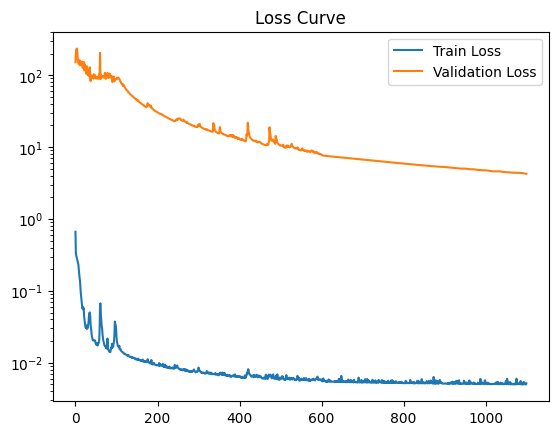

In [13]:
torch.save(model, 'model.pth')
print('best epoch: ', best_epoch + 1)

plt.plot(train_loss, label="Train Loss")
plt.plot(validation_loss, label="Validation Loss")
plt.legend()
plt.yscale("log")
plt.title("Loss Curve")
plt.show()

In [14]:
#model = best_model     # least validation does not work well

Test MSE: 4.2421
sample:  1


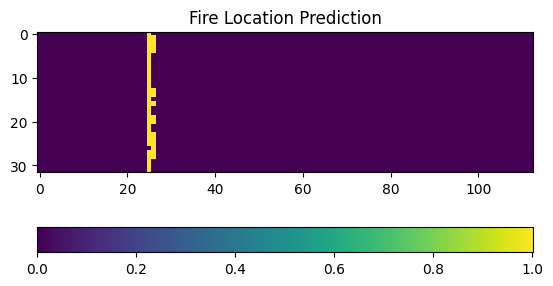

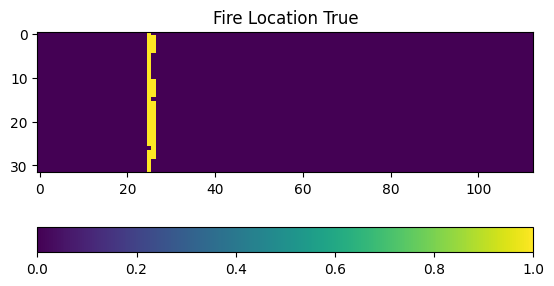

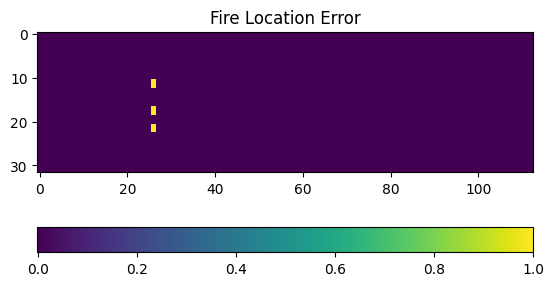

In [15]:
# Evaluate the model on the training and test sets
running_test_loss = 0.0
for xx,yy,tt  in test_loader:
    xx = xx.to(device)
    yy = yy.to(device)
    tt = tt.to(device)
    with torch.no_grad():
        outputs = model(xx, tt*0.)    
        test_loss = criterion(outputs, yy)
    running_test_loss += test_loss.item()
    
# Calculate the MSE test sets
test_mse = running_test_loss/len(test_loader)
print(f"Test MSE: {test_mse:.4f}")

# Plot predictions for a few samples from the test set
sample = 0
for xx,yy,tt  in test_loader:
    sample = sample + 1
    xx = xx.to(device)
    yy = yy.to(device)
    tt = tt.to(device)
    with torch.no_grad():
        outputs = model(xx, tt*0.)    
    
    fire_location_pred = outputs[0,0,2,:,:]
    fire_location_pred = fire_location_pred.detach().cpu().numpy()
    fire_location_true = yy[0,0,2,:,:]
    fire_location_true = fire_location_true.detach().cpu().numpy()
    print("sample: ", sample)
    plt.imshow(fire_location_pred.T)
    plt.colorbar(orientation='horizontal')
    plt.title("Fire Location Prediction")
    plt.show()
    plt.imshow(fire_location_true.T)
    plt.colorbar(orientation='horizontal')
    plt.title("Fire Location True")
    plt.show()
    err = (fire_location_true.T - fire_location_pred.T)
    plt.imshow(err)
    plt.colorbar(orientation='horizontal')
    plt.title("Fire Location Error")
    plt.show()
        
    if sample >= 5:
        break

# # Prepare submission file
# y_preds = {test_df['id'][idx]: pred_test_grid[idx][5:25].flatten(order='C').astype(np.float32) for idx in range(len(test_df))}

# df = pd.DataFrame.from_dict(y_preds, orient='index')
# df['id'] = df.index
# df = df.reset_index(drop=True)
# cols = ['id'] + df.columns.tolist()[:-1]
# df = df[cols]

# df.to_csv('submission.csv', index=False)

In [16]:
# Submission generation 
# 20 autoregression steps for 27 test samples
y_preds = {}
ids = []
for idx in range(len(test_df)):
    theta, ustar, xi_f, uin, alpha, id = load_dataX(idx, test_df, 'test')
    
    theta = torch.Tensor(theta).unsqueeze(1)
    ustar = torch.Tensor(ustar).unsqueeze(1)
    xi_f = torch.Tensor(xi_f).unsqueeze(1)
    
    uin_tensor = torch.zeros_like(xi_f) + uin
    alpha_tensor = torch.zeros_like(xi_f) + alpha
    
    TUXUA = torch.cat([theta,ustar,xi_f, uin_tensor, alpha_tensor], dim=1)
    TUXUA = TUXUA.unsqueeze(0)
    
    xx = TUXUA[:,-history:,...]
    xx = xx.to(device)
    
    fire_loc = []
    for i in range(20):
        with torch.no_grad():        
            output = model(xx, torch.zeros(1).to(device)) 
            Temp = torch.cat([output,xx[:,-1:,-2:,:,:]], dim=2) 
            xx = torch.cat([xx[:,1:,:,:,:], Temp], dim=1)
            fire_loc.append(output[0,:,2,:,:])
    
    fire_location20 = torch.cat(fire_loc, dim=0)
    fire_location20 = fire_location20.detach().cpu().numpy().flatten(order='C').astype(np.float32)
    
    y_preds[id]= fire_location20
    ids.append(id)

df = pd.DataFrame.from_dict(y_preds,orient='index')
df['id'] = ids
#df.info()

#move id to first column
cols = df.columns.tolist()
cols = cols[-1:] + cols[:-1]
df = df[cols]
#reset index
df = df.reset_index(drop=True)

#df.head()
df.info()
df.to_csv('submission.csv',index=False)
print('Generated Submission file' )

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27 entries, 0 to 26
Columns: 72321 entries, id to 72319
dtypes: float32(72320), int64(1)
memory usage: 7.4 MB
Generated Submission file
